# MileEnd Audio Classification of Spoken Numerals

This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in the dataset, and each item is described by four attributes:

1. File ID (audio file)
2. Numeral
3. Participand ID
4. Intonation

**To download the dataset**

QMUL link for dataset: https://collect.qmul.ac.uk/down?t=4LO0R0TSLPGGHJPC/45O137K56GGVDFUT9AH4ST0

### **Importing the required libraries**

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
import sklearn
from sklearn.preprocessing import LabelEncoder
drive.mount('/content/drive')

Mounted at /content/drive


**Verify whether the drive is mounted and have the dataset.**

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

Below cells have to be commented after executing for the first time to avoid downloading the data again.

**Define a function that will allow to download a file into a chosen location.**

In [ ]:
#def download_url(url, save_path):
    #with urllib.request.urlopen(url) as dl_file:
        #with open(save_path, 'wb') as out_file:
            #out_file.write(dl_file.read())

**Download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'**

In [ ]:
#url  = "https://collect.qmul.ac.uk/down?t=4LO0R0TSLPGGHJPC/45O137K56GGVDFUT9AH4ST0"
#save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
#download_url(url, save_path)

**Unzip the training file**

In [ ]:
#directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
#with zipfile.ZipFile(save_path, 'r') as zip_ref:
    #zip_ref.extractall(directory_to_extract_to)

##1. Exploring the Data

Checking the total length of the audio dataset

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
print("The number of audio files in training dataset : ",len(files))


The number of audio files in training dataset :  20000


Listening to three random audio files

In [ ]:
# three random files
for _ in range(3):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

##1.2 Loading the Dataset

 Read the Audio data files into a Pandas DataFrame and storing it in a variable called labels.

In [ ]:
#read the file into a variable labels
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
# Viewing samples from the data
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


Eliminate any null values if present in the dataset.

In [ ]:
labels.isnull().sum()

File ID        0
digit_label    0
participant    0
intonation     0
dtype: int64

Check for any duplicate values

In [ ]:
labels.duplicated()
print("Duplicate values : ",labels.duplicated().any())

Duplicate values :  False


To check the number of samples for each class

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


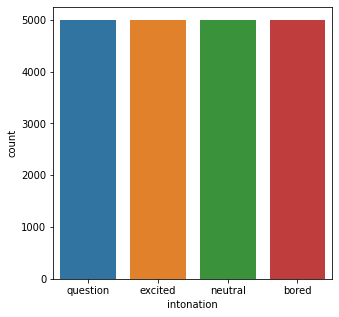

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(labels['intonation'])

## **2. Data Preprocessing**

 Number of samples in one of the audio files

In [ ]:
fs=None
for _ in range(5):
  x, fs = librosa.load(files[np.random.randint(20000)],sr=fs)
  print("The selected file has",x.shape[0],"samples")

The selected file has 41216 samples
The selected file has 30208 samples
The selected file has 46848 samples
The selected file has 28928 samples
The selected file has 45646 samples


Plotting one of the audio signal

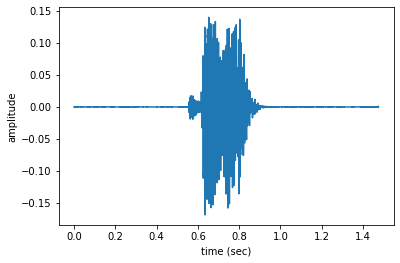

In [ ]:
n=5589
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

Can see how the data is distributed

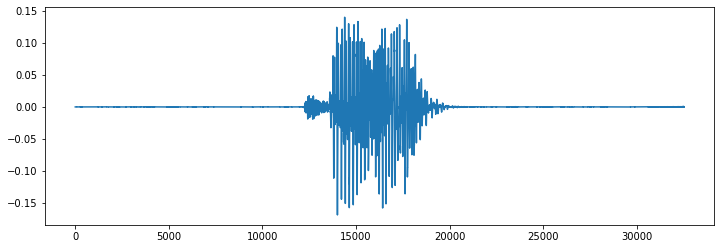

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(x)

## **2.1.Feature extraction**


Extracting a few features from the signals and use these features instead as predictors. In the following cell, a function is defined that extracts ten features from an audio signal, namely:

1. Power

2. Pitch mean

3. Pitch standard deviation

4. Fraction of voiced region
5. Spectral Centroid
6. Spectral Bandwidth
7. Spectral RollOff
8. Zero Crossing Rate 
9. Chroma STFT
10. MelSpectrogram

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
# Normalization function for features

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

 Identifying Intonation from the extracted features. Using LabelEncoder function to convert the intonations 'Question', 'Exicited', 'Neutral' and 'Bored' into labels '0, 1, 2, 3'. The extracted features are the predictors. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 10 audio features used as predictors (X) and their labels (y).

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files, position=0, leave=True):
    fileID = file.split('/')[-1]
    xi = []
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    #Power  
    power = np.sum(x**2)/len(x)
    #Pitch mean
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    #Pitch standard deviation
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    #Fraction of voiced region
    voiced_fr = np.mean(voiced_flag)

    xi.append(power)
    xi.append(pitch_mean)
    xi.append(pitch_std)
    xi.append(voiced_fr)

    # Spectral Centroid
    xi.append(np.mean(normalize(librosa.feature.spectral_centroid(x, sr=fs)[0])))  
    # Spectral Bandwidth
    xi.append(np.mean(normalize(librosa.feature.spectral_bandwidth(x, sr=fs)[0])))
    # Spectral RollOff
    xi.append(np.mean(normalize(librosa.feature.spectral_rolloff(x, sr=fs)[0])))  
    # Zero Crossing Rate  
    xi.append(np.mean(librosa.feature.zero_crossing_rate(x)))
    # Chroma STFT
    xi.append(np.mean(librosa.feature.chroma_stft(x, sr=fs)))
    # MelSpectrogram
    xi.append(np.mean([np.mean(i) for i in normalize(librosa.feature.melspectrogram(y=x, sr=fs))]))

    X.append(xi)
    y.append(yi)
    # transform non-numerical labels
    label_encoder = LabelEncoder()
    y_labeled = label_encoder.fit_transform(y)
    label_classes = label_encoder.classes_
  return np.array(X),np.array(y_labeled), label_classes, y_labeled


Applying getXy function to the whole dataset(20000 audio files)

In [ ]:
X,y,label_classes, y_labeled = getXy(files, labels_file=labels,scale_audio=True, onlySingleDigit=True)
#print(label_classes)
#print(y_labeled)
#X


  2%|▏         | 481/20000 [04:46<3:30:00,  1.55it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
 24%|██▍       | 4900/20000 [48:41<2:17:34,  1.83it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
 50%|█████     | 10011/20000 [1:38:11<1:32:30,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
 67%|██████▋   | 13406/20000 [2:10:56<57:31,  1.91it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning f

Encoded labeled classes

In [ ]:
print("The shape of X : ",X.shape)
print("The shape of y : ",y.shape)
print("The labels vector : ",y)
print("The encoded labelled classes : ",label_classes)

The shape of X :  (20000, 10)
The shape of y :  (20000,)
The labels vector :  [0 3 1 ... 1 2 0]
The encoded labelled classes :  ['bored' 'excited' 'neutral' 'question']


Saving the extracted features file to the drive as it can be loaded later and used, instead of extracting it again.

In [ ]:
np.save("x_20k.npy", X)
np.save("y_20k.npy", y)

Loading the saved file x_20k.npy and y_20k.npy 

In [ ]:
x_preprocessed = np.load("drive/MyDrive/x_20k.npy")
y_preprocessed = np.load("drive/MyDrive/y_20k.npy")


Extracted feature predicts the class whether its 'bored, neutral, question, exited'

In [ ]:
print(x_preprocessed[70],y_preprocessed[70])


[1.08779712e-02 1.11644669e+02 9.11027741e+00 2.50000000e-01
 6.45128228e-01 7.47373604e-01 6.99051655e-01 1.23073033e-01
 6.18049622e-01 3.14704031e-02] 2


## **3.Splitting Data**

Manually spliting the data for training and validation set.

In [ ]:
x_train, x_val = x_preprocessed[:17000], x_preprocessed[17000:20000]
y_train, y_val = y_preprocessed[:17000], y_preprocessed[17000:20000]
print("The shape of x_train : ",x_train.shape)
print("The shape of x_val : ",x_val.shape)
print("The shape of y_train : ", y_train.shape)
print("The shape of y_val : ", y_val.shape)

The shape of x_train :  (17000, 10)
The shape of x_val :  (3000, 10)
The shape of y_train :  (17000,)
The shape of y_val :  (3000,)


In [ ]:
#Shuffiling the x and y training dataset
shuffle_index = np.random.permutation(17000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# **4.Models**

Experimenting with different classification models before selecting an appropriate final model.

1. Logistic Regression Classifier
2. Support Vector Machines(SVM)
3. SVM with normalized values and tuned parameters using grid search
4. KNN classifier


## **4.1.Training and Validation**

## **4.1.1.Logistic Regression linear classifier**

Training and fitting the Logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

# Here fit the logistic regression classfier to the training dataset 
log_reg_classifier = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial',max_iter=2000)
log_reg_classifier.fit(x_train, y_train)
y_train_pred = log_reg_classifier.predict(x_train)
y_val_pred = log_reg_classifier.predict(x_val)

# extract and print the accuracy 
LR_val_acc = np.mean(y_val_pred==y_val)
print('Training Accuracy', np.mean(y_train_pred==y_train))
print('Validation  Accuracy', LR_val_acc)


Training Accuracy 0.5130588235294118
Validation  Accuracy 0.5106666666666667


### **4.1.2.Support Vector Machines**

Built a support vector machine (SVM) model for the predictive task of identifying digits in an audio signal, using the dataset that we have been created and printing the training and validation accuracy.

In [ ]:
from sklearn import svm
classifier_model  = svm.SVC(C=1,kernel='poly')
classifier_model.fit(x_train,y_train)

y_train_p = classifier_model.predict(x_train)
y_val_p = classifier_model.predict(x_val)

PSVM_val_acc = np.mean(y_val_p==y_val)
print('Training Accuracy', np.mean(y_train_p==y_train))
print('Validation  Accuracy', PSVM_val_acc)


Training Accuracy 0.42311764705882354
Validation  Accuracy 0.4146666666666667


SVM classifier with default parameters doesn't improve the performance of the model.

### **4.1.3.Performing grid search to find tuned parameters for SVM model.**

In [ ]:
param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.499, total=  18.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.494, total=  17.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.9s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.479, total=  18.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.484, total=  18.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.482, total=  17.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.509, total=  15.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.502, total=  14.9s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.491, total=  15.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.494, total=  15.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 40.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
#normalizing the predictors
mean = x_train.mean(0)
sd =  x_train.std(0)

x_train = (x_train-mean)/sd
x_val  = (x_val-mean)/sd

model_svm  = svm.SVC(C=1000,gamma=0.001,kernel='rbf')
model_svm.fit(x_train,y_train)

y_train_p = model_svm.predict(x_train)
y_val_p = model_svm.predict(x_val)

RBF_val_acc = np.mean(y_val_p==y_val)
print('Training Accuracy', np.mean(y_train_p==y_train))
print('Validation  Accuracy', RBF_val_acc)

Training Accuracy 0.5505294117647059
Validation  Accuracy 0.5406666666666666


### **4.1.4.K-Nearest Neighbor classifier**

After exprementing with different values of K , finally k = 3 gives better accuracy than the other values.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(x_train, y_train)
y_train_p = knn_clf.predict(x_train)
y_val_p = knn_clf.predict(x_val)

KNN_val_acc = np.mean(y_val_p==y_val)
print('Training Accuracy', np.mean(y_train_p==y_train))
print('Validation  Accuracy', KNN_val_acc)


Training Accuracy 0.6881176470588235
Validation  Accuracy 0.44533333333333336


## **5.Evaluation and Selection of model**

Creating a dataframe with the experimented models and their accuracy.

In [ ]:
names = ["Logistic_Regression", "Polynomial_SVM", "RBF_SVM", "Nearest_Neighbors"]
scores = []
scores.append(LR_val_acc)
scores.append(PSVM_val_acc)
scores.append(RBF_val_acc)
scores.append(KNN_val_acc)

df = pd.DataFrame()

df['names'] = names
df['scores'] = scores 
df

,names,scores
0,Logistic_Regression,0.510667
1,Polynomial_SVM,0.414667
2,RBF_SVM,0.544000
3,Nearest_Neighbors,0.430000


Comparing the performance of all the experimented models. It can be seen that the SVM classifier with tuned parameter outperforms all the other models.

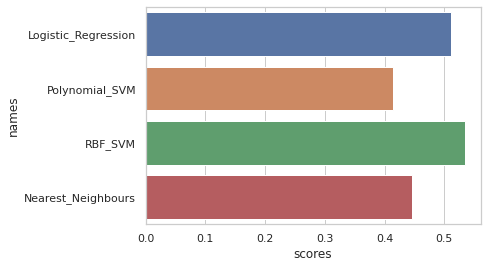

In [ ]:
sns.set(style='whitegrid')
ax = sns.barplot(y='names', x='scores',data=df)

Training the data with more training data

In [ ]:
x_train, x_val = x_preprocessed[:19500], x_preprocessed[19500:20000]
y_train, y_val = y_preprocessed[:19500], y_preprocessed[19500:20000]
print("The shape of x_train : ",x_train.shape)
print("The shape of x_val : ",x_val.shape)
print("The shape of y_train : ", y_train.shape)
print("The shape of y_val : ", y_val.shape)

The shape of x_train :  (19500, 10)
The shape of x_val :  (500, 10)
The shape of y_train :  (19500,)
The shape of y_val :  (500,)


In [ ]:
shuffle_index = np.random.permutation(19000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

Fitting SVM tuned parameters 

In [ ]:
mean = x_train.mean(0)
sd =  x_train.std(0)

x_train = (x_train-mean)/sd
x_val  = (x_val-mean)/sd

rbf_svm  = svm.SVC(C=1000,gamma=0.001,kernel='rbf')
rbf_svm.fit(x_train,y_train)

y_train_p = rbf_svm.predict(x_train)
y_val_p = rbf_svm.predict(x_val)

RBF_val_acc = np.mean(y_val_p==y_val)
print('Training Accuracy', np.mean(y_train_p==y_train))
print('Validation  Accuracy', RBF_val_acc)

Training Accuracy 0.5527179487179488
Validation  Accuracy 0.544


Even though training with more data, the model doesn't make any significant difference in the performance. Extracting more features may improve model's performance.  

In [ ]:
import pickle
pickle.dump(model6_svm, open('/content/model_SVM_19900_70_v1.pkl', 'wb'))

import pickle
# open a file, where to store the data
file = open('/content/rbf_svm_model.pkl', 'wb')

# dump information to that file
pickle.dump(rbf_svm, file)